In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from FE621.pricing.black_scholes import BlackScholes

# FE621 Homework 1
Cian Gahan

**<span style="color: red">NOTE</span>:** When setting up and running my data gathering script, I misread the assignment instructions and downloaded option/price data for the SPX index rather than the SPY ETF. I did not realize this until after Thursday's trading hours and therefore could not switch out the data for the correct ticker. I anticipate the results will be very similar. Vol/open interest relative to the contract size being 10x as much seems in line with SPY on yahoo finance when I checked, potentially smaller. I would anticipate liquidity is at worst similar since the granularity of contracts is higher on SPX (every 5 index points at the money, where SPY trades around 1/10th the value and has every $1-spaced options at the money), and SPY mostly does a good job tracking SPX so I don't think this will have a major impact on analysis or results.

Moving forward in the assignment I will use SPX in place of SPY.

## Part 1: Data Gathering Component
### 1.1: Data Gathering Function & Bonus
- See ```scripts/hw1_yf_ingest.py``` for raw ingestion
- See ```scripts/hw1_yf_ingest_cleaner.py``` for cleaning/combination
### 1.2:
- Why do additional maturities exist? Given that TSLA, SPX, and VIX are all highly liquid, popular tickers with a lot of speculative interest, traders have demand for products that speculate on volatility/short term movements with finer control over the time window than the traditional monthly schedule, especially as the maturity date approaches. Therefore exchanges/market makers introduce options with more maturities as these dates approach, meeting demand without fragmenting long-term maturity liquidity (eg a month or two out, weekly options may be introduced, and a week or so out, daily options may be introduced in the case of SPX).

In [2]:
# load in options and price data
options = pd.read_csv("../data/cleaned/options.csv", index_col=0)
print(options.head())

       contractSymbol  strike   bid   ask optionType  expiration underlying  \
0  VIX260218C00010000    10.0  9.75  10.4       call  2026-02-18       ^VIX   
1  VIX260218C00010500    10.5  9.25   9.9       call  2026-02-18       ^VIX   
2  VIX260218C00011000    11.0  8.75   9.4       call  2026-02-18       ^VIX   
3  VIX260218C00011500    11.5  8.25   8.9       call  2026-02-18       ^VIX   
4  VIX260218C00012000    12.0  7.75   8.4       call  2026-02-18       ^VIX   

    data_date  daysToMaturity  underlyingPrice  fedFunds  
0  2026-02-12               6        19.879999    0.0364  
1  2026-02-12               6        19.879999    0.0364  
2  2026-02-12               6        19.879999    0.0364  
3  2026-02-12               6        19.879999    0.0364  
4  2026-02-12               6        19.879999    0.0364  


### 1.3:
- SPX: Index published by S&P consisting of a market-cap weighted average of ~500 of the largest companies trading in the US stock market. Purpose is to provide a measure of overall US stock market performance
- SPY: ETF that tracks the SPX index, managed by State Street. Purpose is to gain easy exposure to the entire US stock market
- VIX: Index published by CBOE that estimates 30 day market-implied volatility using a weighted combination of implied volatilities calculated from out-of-the-money SPX call and put options between 23 and 37 days to maturity. Purpose is to provide a measure for expected volatility and allow for trading/speculation on it directly
- TSLA: Tesla Stock. Purpose is to invest in Tesla
- Example option symbol decomposition: 
    * TICKERYYMMDD{C/P}STRIKE (strike listed as XXXXX.XXX fixed-point)
    * eg TSLA260220C00450000 - tesla call maturing on Feb 20th with strike $450.
    * Note on SPX options: Options may be listed with tickers as SPX or SPXW in raw data. SPXW are typically found in the finer-grain weekly maturities but may also exist at certain prices in the traditional maturity dates. The mechanical difference is that SPXW expire/are settled using VWAP near the end of the trading day on Friday, while SPX expire at the opening auction on Friday. To simplify analysis I removed this distinction while cleaning the data and am measuring time to maturity as the number of days

### 1.4:
- For short term interest rate I used the Fed Funds (effective) rate from the Fed website which was 3.64% for both days in my data

## Part 2: Analysis of the Data
### 2.5:
- Black-Scholes Implementation: See ```FE621/pricing/black_scholes.py```
### 2.6:
- Bisection Method: See ```FE621/utils.py```
- Note: I found that implied volatility would not converge for much of the options (could not find clear pattern and option quotes seemed off from intrinsic value when checked so presumably stale quotes/data issue) so I replaced non converging values with nan here

In [3]:
def row_iv(row):
    if row["optionType"] == "call":
        return BlackScholes.iv_call_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )
    else:
        return BlackScholes.iv_put_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )

options["impliedVolatilityB"] = options.apply(row_iv, axis=1)

In [4]:
options["moneyness"] = options["underlyingPrice"] / options["strike"]
options["abs_moneyness"] = (options["underlyingPrice"] - options["strike"]).abs()

def timeval(row):
    if row["optionType"] == "call":
        return (row["bid"] + row["ask"]) / 2 - np.max(row["underlyingPrice"] - row["strike"], 0)
    else:
        return (row["bid"] + row["ask"]) / 2 - np.max(row["strike"] - row["underlyingPrice"], 0)

options["timeval"] = options.apply(timeval, axis=1)

data1 = options[options["data_date"] == "2026-02-12"]

spx_first = data1[(data1["underlying"] == "^SPX") & (data1["expiration"] == "2026-02-20")]
tsla_first = data1[(data1["underlying"] == "TSLA") & (data1["expiration"] == "2026-02-20")]

spx_atm = spx_first[spx_first["abs_moneyness"] == spx_first["abs_moneyness"].min()]
tsla_atm = tsla_first[tsla_first["abs_moneyness"] == tsla_first["abs_moneyness"].min()]

spx_range_atm = spx_first[(spx_first["moneyness"] >= 0.95) & (spx_first["moneyness"] <= 1.05)]
tsla_range_atm = tsla_first[(tsla_first["moneyness"] >= 0.95) & (tsla_first["moneyness"] <= 1.05)]

spx_atm_iv = spx_atm["impliedVolatilityB"].mean()
tsla_atm_iv = tsla_atm["impliedVolatilityB"].mean()

spx_range_atm_iv = spx_range_atm["impliedVolatilityB"].mean()
tsla_range_atm_iv = tsla_range_atm["impliedVolatilityB"].mean()

print("SPX at the money: " + str(spx_atm_iv))
print("SPX around the money: " + str(spx_range_atm_iv))
print("TSLA: " + str(tsla_atm_iv))
print("TSLA around the money: " + str(tsla_range_atm_iv))

SPX at the money: 0.16649494394962489
SPX around the money: 0.16960305650260124
TSLA: 0.41606047321558
TSLA around the money: 0.42085042494567787


### 2.7:
- Newton Method: See ```FE621/utils.py```

In [5]:
def row_iv_newton(row):
    if row["optionType"] == "call":
        return BlackScholes.iv_call_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )
    else:
        return BlackScholes.iv_put_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )

options["impliedVolatilityN"] = options.apply(row_iv_newton, axis=1)

/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  x = x - fx / fpx
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: overflow encountered in scalar divide
  x = x - fx / fpx


In [6]:
print("Maximum ivol difference (Bisection vs Newton): " + str((options["impliedVolatilityB"] - options["impliedVolatilityN"]).abs().max()))

Maximum ivol difference (Bisection vs Newton): 1.441229731091731e-05


We can see that the implied volatility converges to essentially the same values for both newton and bisection methods

In [7]:
def iter_bisection(row):
    if row["optionType"] == "call":
        _, i = BlackScholes.iv_call_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter = True
        )
        return i
    else:
        _, i = BlackScholes.iv_put_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter = True
        )
        return i

def iter_newton(row):
    if row["optionType"] == "call":
        _, i = BlackScholes.iv_call_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter=True
        )
        return i
    else:
        _, i = BlackScholes.iv_put_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter=True
        )
        return i

iters_bisection = options.apply(iter_bisection, axis=1)
iters_newton = options.apply(iter_newton, axis=1)

/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  x = x - fx / fpx
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: overflow encountered in scalar divide
  x = x - fx / fpx


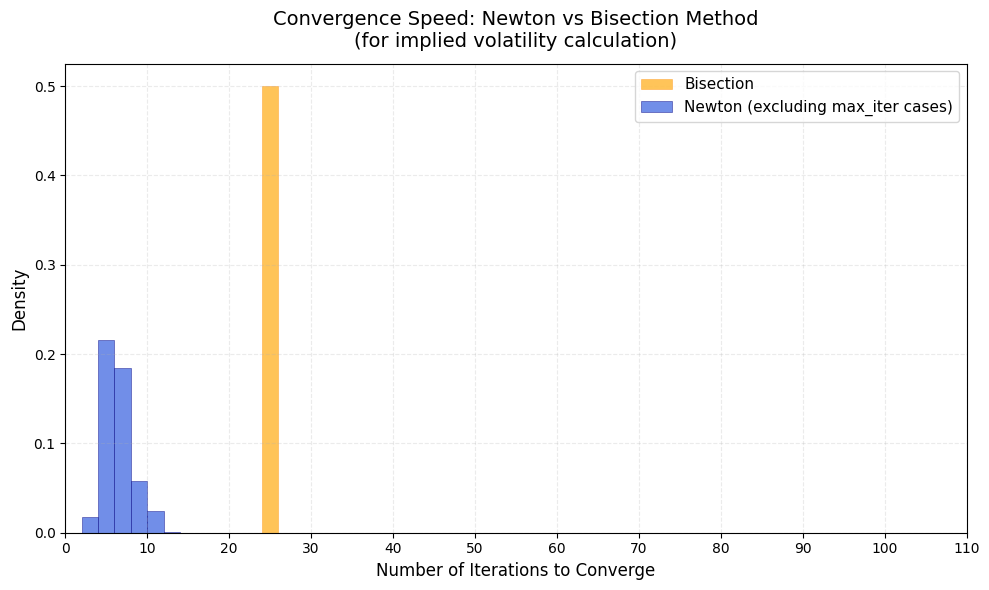

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(iters_bisection,
        bins=np.arange(0, 51, 2),
        alpha=0.65,
        label='Bisection',
        color='orange',
        density=True,
        edgecolor='darkorange',
        linewidth=0.4)

ax.hist(iters_newton[iters_newton != 100],
        bins=np.arange(0, 51, 2),
        alpha=0.75,
        label='Newton (excluding max_iter cases)',
        color='royalblue',
        density=True,
        edgecolor='navy',
        linewidth=0.4)

ax.set_xlabel('Number of Iterations to Converge', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Convergence Speed: Newton vs Bisection Method\n(for implied volatility calculation)', fontsize=14, pad=12)

ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.25, linestyle='--')
ax.set_xlim(0, 110)                       # give a bit of space on right
ax.set_xticks(np.arange(0, 111, 10))

plt.tight_layout()
plt.show()

The newton method clearly converges faster, although it has some variability it seems even the worst cases take less iterations than bisection (noting that each Newton iteration also requires a derivative calculation, so the trade off may be less obvious in practice)

### 2.8:
- To avoid skewing results with high OTM/ITM implied vols, I used the same moneyness thresholds from earlier for each stock/option type/maturity combination and averaged the results for the table

In [9]:
data1 

,contractSymbol,strike,bid,ask,optionType,expiration,underlying,data_date,daysToMaturity,underlyingPrice,fedFunds,impliedVolatilityB,moneyness,abs_moneyness,timeval
0,VIX260218C00010000,10.0,9.75,10.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.590312,1.988000,9.879999,0.195001
1,VIX260218C00010500,10.5,9.25,9.9,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.370347,1.893333,9.379999,0.195001
2,VIX260218C00011000,11.0,8.75,9.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.160400,1.807273,8.879999,0.195001
3,VIX260218C00011500,11.5,8.25,8.9,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,2.959408,1.728696,8.379999,0.195001
4,VIX260218C00012000,12.0,7.75,8.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,2.766438,1.656667,7.879999,0.195001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,SPXW260417P10400000,10400.0,3445.00,3467.8,put,2026-04-17,^SPX,2026-02-12,64,6861.810059,0.0364,NaN,0.659789,3538.189941,-81.789941
3787,SPX260417P10800000,10800.0,3782.10,3800.2,put,2026-04-17,^SPX,2026-02-12,64,6861.810059,0.0364,NaN,0.635353,3938.189941,-147.039941
3788,SPX260417P11200000,11200.0,4177.80,4195.9,put,2026-04-17,^SPX,2026-02-12,64,6861.810059,0.0364,NaN,0.612662,4338.189941,-151.339941
3789,SPX260417P11600000,11600.0,4648.00,4666.1,put,2026-04-17,^SPX,2026-02-12,64,6861.810059,0.0364,NaN,0.591535,4738.189941,-81.139941


### 2.9:
- To save time I just aggregated all options with a corresponding pair using a left join on a call-filtered version of the dataframe and calculated put-call parity for each

In [10]:
# TODO
# - filter dataframe for calls only (data1)
# execute left join with original dataframe, pulling in puts that match the option's strike, maturity, and underlying
# Calculate put-call parity balance for each
# plot histogram/etc for each stock

### 2.10:
- TODO

### 2.11:
- See ```FE621/pricing/black_scholes.py``` for implementation

### 2.12:
- TODO - use data2 vars with data1 implied vol
- right join implied vol data1 onto data2
- calculate implied price
- compare prices

## Part 3: Numerical Integration of AMM Arbitrage Fee Revenue

In [11]:
plt.scatter(spx_first[spx_first["optionType"] != "all"]["strike"], spx_first[spx_first["optionType"] != "all"]["impliedVolatility"])
plt.show()

KeyError: 'impliedVolatility'

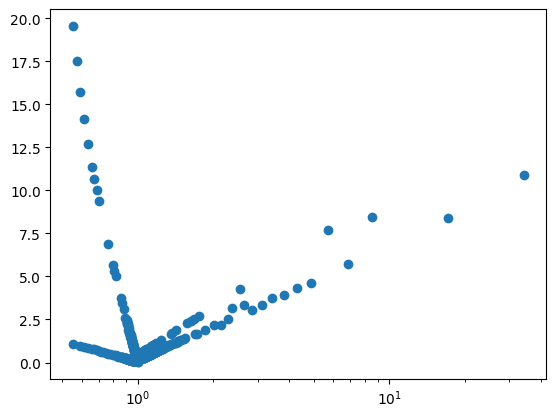

In [ ]:
plt.scatter(spx_first["moneyness"], spx_first["impliedVolatility"])
plt.xscale('log')
plt.show()

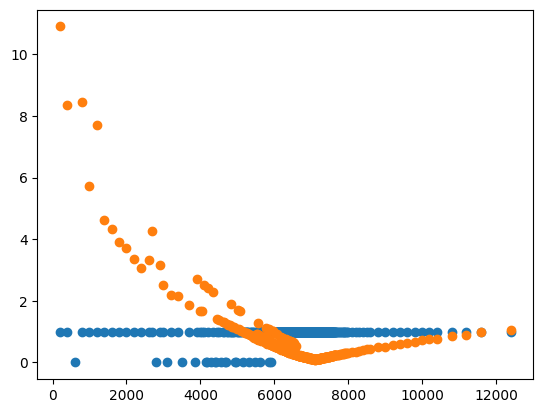

In [ ]:
test_df = options[(options["underlying"] == "^SPX") & (options["data_date"] == "2026-02-12") & (options["expiration"] == "2026-02-20") & (options["optionType"] == "call")]
plt.scatter(test_df["strike"], test_df["impliedVolatility"].notna())
plt.scatter(test_df["strike"], test_df["impliedVolatility"])